## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [1]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

/tmp/ipykernel_1076/442083246.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(d)** Test your sentiment-classifier on the test set.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [2]:
from sklearn.model_selection import train_test_split

# Split data into 3 sets: 64% train, 16% validation, 20% test
X_rest,  X_test, y_rest, y_test = train_test_split(reviews, Y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=0.2, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape)



(16000, 1) (4000, 1) (5000, 1)


In [3]:
X_train.values.shape

(16000, 1)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)

X_train = vectorizer.fit_transform(X_train.values.flatten())

X_val = vectorizer.transform(X_val.values.flatten())

X_test = vectorizer.transform(X_test.values.flatten())

In [5]:
print(X_train.shape)

print(X_train[4])

(16000, 10000)
  (0, 6146)	6
  (0, 8985)	4
  (0, 5829)	1
  (0, 4693)	2
  (0, 9670)	1
  (0, 8941)	8
  (0, 3378)	4
  (0, 8939)	1
  (0, 5390)	1
  (0, 248)	1
  (0, 9846)	2
  (0, 501)	1
  (0, 4680)	5
  (0, 324)	8
  (0, 4080)	1
  (0, 3829)	1
  (0, 6191)	3
  (0, 840)	2
  (0, 4190)	1
  (0, 6189)	1
  (0, 3611)	1
  (0, 3884)	2
  (0, 4779)	1
  (0, 6484)	1
  (0, 4442)	3
  :	:
  (0, 8913)	1
  (0, 7730)	1
  (0, 9953)	1
  (0, 5802)	1
  (0, 9012)	1
  (0, 2302)	1
  (0, 3727)	1
  (0, 1586)	1
  (0, 3255)	1
  (0, 5263)	1
  (0, 650)	1
  (0, 3497)	1
  (0, 5587)	1
  (0, 6632)	1
  (0, 8700)	1
  (0, 6829)	1
  (0, 5403)	1
  (0, 3534)	1
  (0, 5299)	1
  (0, 430)	1
  (0, 4054)	1
  (0, 8712)	1
  (0, 9273)	1
  (0, 5634)	1
  (0, 7551)	1


As a result of vectorization we get a matrix of size n x m, where n is the number of reviews and m is the number of words in the vocabulary. Each row corresponds to a review, and each column to a word. The value of the matrix at position (i, j) is the number of times word j appears in review i.

In [6]:
from cgi import test
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras import optimizers


def create_model(hidden_layer_size, activation, learning):
    model = Sequential() 
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units = hidden_layer_size, activation=activation))

    # using sigmoid and only 1 output neuron because we are doing binary classification
    model.add(Dense(units = 1, activation='sigmoid')) 

    # learning decay, meaning that the learning rate will decrease over time
    # that way we can start with a high learning rate and then decrease it as we get closer to the minimum
    # making sure that we don't overshoot it
    lr_decay = optimizers.schedules.ExponentialDecay(initial_learning_rate=learning, decay_steps=100000, decay_rate=0.90, staircase=True)

    sgd = optimizers.SGD(learning_rate = lr_decay)
    # using binary_crossentropy because we are doing binary classification
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

    return model


# hyperparameters grid
# leaky_relu is variation of relu that allows a small gradient when the unit is not active instead of zero
param_grid = {
    'hidden_layer_size': [32, 64, 96, 128, 256],
    'activation': ['relu', 'tanh', 'leaky_relu'],
    'learning': [0.001, 0.01, 0.1, 0.2],
}

best_acc = 0
best_params = {}

for h in param_grid['hidden_layer_size']:
    for a in param_grid['activation']:
        for l in param_grid['learning']:
            model = create_model(h, a, l)

            history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

            val_accuracy = history.history['val_accuracy'][-1]
            test_accuracy = history.history['accuracy'][-1]

            # to avoid overfitting we only will consider high val accuracy
            # if the difference between val and test accuracies is less than 5%
            if val_accuracy > best_acc and test_accuracy - val_accuracy < 0.05:
                print(f'New best accuracy: {val_accuracy}')
                best_params = {
                        'hidden_layer_size': h,
                        'activation': a,
                        'learning': l,
                }
                best_acc = val_accuracy

print(f'Best accurracy: {best_acc}')
print(f'Best accurracy found for params: {best_params}')




/tmp/ipykernel_1076/1545595926.py:1: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  from cgi import test
2024-05-15 07:59:28.343704: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 07:59:28.416453: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 07:59:28.739132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 07:59:30.024926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5589 - loss: 0.6844 - val_accuracy: 0.6270 - val_loss: 0.6501
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6352 - loss: 0.6458 - val_accuracy: 0.6735 - val_loss: 0.6227
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6781 - loss: 0.6196 - val_accuracy: 0.6973 - val_loss: 0.6027
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7029 - loss: 0.5977 - val_accuracy: 0.7128 - val_loss: 0.5853
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7175 - loss: 0.5806 - val_accuracy: 0.7322 - val_loss: 0.5709
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7295 - loss: 0.5663 - val_accuracy: 0.7492 - val_loss: 0.5560
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7503 - loss: 0.5503 - val_accuracy: 0.7600 - val_loss: 0.5423
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7653 - loss: 0.5343 - val_accuracy: 0.

In [18]:
# know we know the best hyperparameters we can train the model for the same amount of epochs
# then we will plot the loss to see if the model converged already, if not we can increase the number of epochs

model = create_model(**best_params)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6229 - loss: 0.7038 - val_accuracy: 0.7755 - val_loss: 0.4937
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7558 - loss: 0.5344 - val_accuracy: 0.8075 - val_loss: 0.4467
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7918 - loss: 0.4626 - val_accuracy: 0.8305 - val_loss: 0.3972
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8171 - loss: 0.4185 - val_accuracy: 0.7818 - val_loss: 0.4550
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8270 - loss: 0.3986 - val_accuracy: 0.8520 - val_loss: 0.3641
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8459 - loss: 0.3638 - val_accuracy: 0.8152 - val_loss: 0.4076
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8476 - loss: 0.3530 - val_accuracy: 0.8508 - val_loss: 0.3445
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8583 - loss: 0.3359 - val_accu

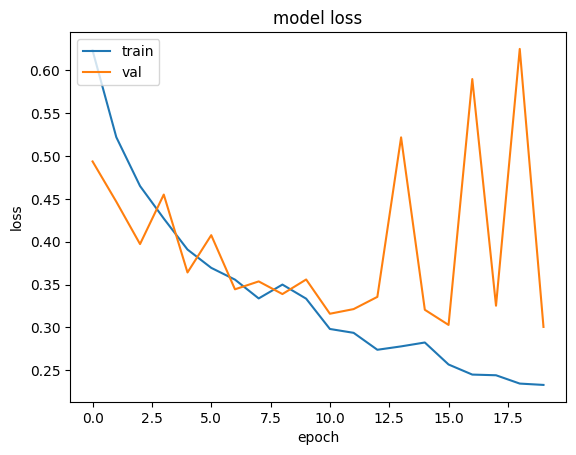

In [19]:
# lets plot training loss and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')

plt.show()

looks like we still haven't converged, so let's train a little bit more, but with much smaller learning rate not to overshoot the loss minimum.

In [20]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), initial_epoch=20)

Epoch 21/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9177 - loss: 0.2088 - val_accuracy: 0.8655 - val_loss: 0.3376
Epoch 22/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9178 - loss: 0.2449 - val_accuracy: 0.8497 - val_loss: 0.3588
Epoch 23/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9214 - loss: 0.2054 - val_accuracy: 0.8737 - val_loss: 0.3051
Epoch 24/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9282 - loss: 0.1937 - val_accuracy: 0.8748 - val_loss: 0.3003
Epoch 25/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9336 - loss: 0.1766 - val_accuracy: 0.8802 - val_loss: 0.3010
Epoch 26/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9379 - loss: 0.1694 - val_accuracy: 0.8788 - val_loss: 0.3040
Epoch 27/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9280 - loss: 0.1964 - val_accuracy: 0.8785 - val_loss: 0.3253
Epoch 28/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9324 - loss: 0.1832 - 

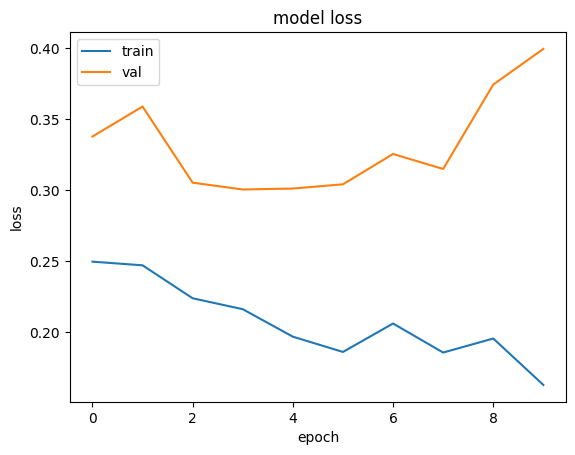

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')

plt.show()

Looks like the model started to overfit, the jumps in validation loss also indicate that. We should probably decrease the learning rate even more, or use some kind of regularization.

In [24]:
# let's evaluate the model on the test set

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8549 - loss: 0.4154
Test accuracy: 0.8489999771118164
Test loss: 0.42955172061920166


In [30]:
# let's use our model to predict few sentences

sentences = [
    "One of the best movies I've ever seen",
    "Leonardo Di Caprio was awful in this movie",
    "This movie is a waste of time",
    "I hate to say it but it was a really good movie",
]

vec_sentences = vectorizer.transform(sentences)

predictions = model.predict(vec_sentences).flatten()


# model outputs values between 0 and 1, we can consider that values above 0.5 are positive and below are negative
# the closer the number is to 1 the bigger confidence the model has that the sentence is positive
# the closer the number is to 0 the bigger confidence the model has that the sentence is negative
for i, p in enumerate(predictions):
    print(f'{sentences[i]}: {"positive" if p > 0.5 else "negative"} ({p} - raw model prediction)')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
One of the best movies I've ever seen: positive (0.9443149566650391 - raw model prediction)
Leonardo Di Caprio was awful in this movie: negative (0.03556955233216286 - raw model prediction)
This movie is a waste of time: negative (0.07536668330430984 - raw model prediction)
I hate to say it but it was a really good movie: positive (0.6752862930297852 - raw model prediction)
